# ph recognition based on the image color
 ***
 
 ### I downloaded ph-scale images from [link](https://www.shutterstock.com/search/ph+scale). Then I split every image to 15 small ones and I labeled it based on the ph

In [2]:
import cv2 # for images
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.externals import joblib
import os
from load_data import LoadData

pd.set_option('display.max_columns', None)

In [3]:
data = LoadData(34)
df = data.load_data()
df = shuffle(df)
df.shape

no image
no image
no image
no image
no image
no image


(504, 4)

In [4]:
y = np.array(df['label']) 
X = np.array(df.drop(['label'], axis=1))
# print(y)

# Plotting 

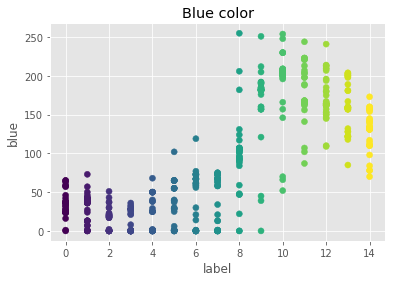

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.scatter(df.label, df.blue, c=df.label)
plt.xlabel('label')
plt.ylabel('blue')
plt.title('Blue color')
plt.show()

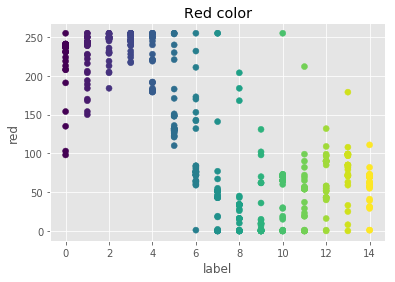

In [6]:
plt.scatter(df.label, df.red, c=df.label)
plt.xlabel('label')
plt.ylabel('red')
plt.title('Red color')
plt.show()

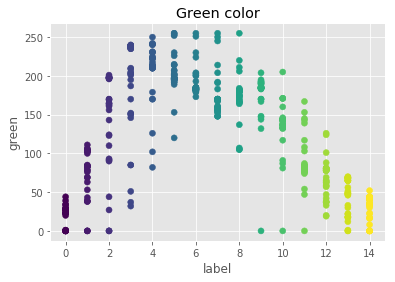

In [7]:
plt.scatter(df.label, df.green, c=df.label)
plt.xlabel('label')
plt.ylabel('green')
plt.title('Green color')
plt.show()

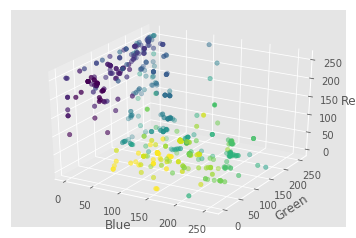

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.blue, df.green, df.red, c=df.label)
ax.set_xlabel('Blue')
ax.set_ylabel('Green')
ax.set_zlabel('Red')

plt.show()
fig.savefig('plot3d_v1.png')

### Plotly 

In [14]:
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
import plotly
plotly.tools.set_credentials_file(username='robertjankowski', api_key='*********')

In [23]:
# make color array 
colors = np.array([df.blue,df.green,df.red])
colors.shape

(3, 504)

In [28]:
ph_colors = go.Scatter3d(
    x=df.blue,
    y=df.green,
    z=df.red,
    mode='markers',
    marker =dict(size=5,color=df.label,colorscale='Viridis'),
    name ='PH-scale'
)

data = [ph_colors]
layout = go.Layout(
    margin = dict(l=0,r=0,b=0,t=0),
    scene = dict(
        xaxis = dict(title='blue'),
        yaxis = dict(title='green'),
        zaxis = dict(title='red'),)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='ph-scale')

# test and train data 

In [29]:
SIZE = X.shape[0]
TRAIN_SIZE = int(SIZE*0.9)
train_x = X[:TRAIN_SIZE]
train_y = y[:TRAIN_SIZE]
test_x = X[TRAIN_SIZE:]
test_y = y[TRAIN_SIZE:]
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((453, 3), (51, 3), (453,), (51,))

# Testing machine learning algorithms

***


#### GradientBoostingRegressor

In [30]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
# clf = GradientBoostingRegressor()
# clf.fit(train_x, train_y)

#### RandomForestRegressor

In [31]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
clf = RandomForestRegressor()
clf.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### GradientBoostingRegressor with tuning

In [32]:
clf = GradientBoostingRegressor(loss='lad', learning_rate=0.2,
                               max_depth=8,)
clf.fit(train_x, train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='lad', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

#### GradientBoostingRegressor choosing best score

In [33]:
from sklearn.model_selection import RandomizedSearchCV
GBR = GradientBoostingRegressor()
GBR.fit(train_x,train_y)
gb_param_grid = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate':[0.1, 0.05, 0.01],
    'max_depth': [4, 8],
    'min_samples_leaf': [1,2,5],
    
}
gsGBR = RandomizedSearchCV(GBR,param_distributions=gb_param_grid,cv=5,verbose=1)
gsGBR.fit(train_x,train_y)
GBR_best = gsGBR.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.7s finished


In [34]:
gsGBR.best_params_, gsGBR.best_score_

({'min_samples_leaf': 2, 'max_depth': 8, 'loss': 'lad', 'learning_rate': 0.05},
 0.9492521336968851)

In [35]:
from sklearn.metrics import r2_score
# testing 
def test(clf):
    accuracy = 0
    for i in range(len(test_x)):
        y_predict = clf.predict([test_x[i]])
        print('Predict {:.2f}, labels {}'.format(y_predict[0],test_y[i]))
        # add some margin
        if(abs(y_predict[0] - test_y[i]) <= 0.3):
            accuracy += 1
    accuracy = float(accuracy/len(test_x))
    print(accuracy)
    # return the mean accuracy on the given test data and labels
    r2 = r2_score(test_y, clf.predict(test_x))
    print(r2)
    return r2
# overfitting !

In [36]:
r2 = test(GBR_best)

Predict 2.06, labels 2
Predict 2.20, labels 5
Predict 9.49, labels 13
Predict 4.26, labels 2
Predict 8.34, labels 11
Predict 7.00, labels 7
Predict 0.27, labels 0
Predict 8.00, labels 8
Predict 2.14, labels 2
Predict 3.95, labels 4
Predict 11.96, labels 12
Predict 9.96, labels 10
Predict 9.13, labels 10
Predict 0.37, labels 1
Predict 8.01, labels 8
Predict 12.23, labels 12
Predict 8.96, labels 11
Predict 13.90, labels 14
Predict 12.00, labels 13
Predict 3.01, labels 3
Predict 12.88, labels 13
Predict 1.99, labels 2
Predict 6.08, labels 6
Predict 5.20, labels 5
Predict 2.23, labels 1
Predict 11.93, labels 12
Predict 6.72, labels 10
Predict 6.00, labels 6
Predict 8.00, labels 8
Predict 3.33, labels 4
Predict 4.95, labels 5
Predict 12.88, labels 13
Predict 12.38, labels 12
Predict 13.08, labels 13
Predict 9.98, labels 10
Predict 1.02, labels 3
Predict 11.00, labels 11
Predict 3.02, labels 3
Predict 6.00, labels 6
Predict 12.49, labels 14
Predict 6.32, labels 6
Predict 3.50, labels 4
Predi

In [37]:
def static_var(varname, value):
    def decorate(func):
        setattr(func, varname, value)
        return func
    return decorate

In [39]:
# pickle save model
@static_var('numer',0)
def save_model(model, name):
    save_model.number += 1
    model_pickle = open('saved_models//34_datasets.pickle','wb')
    pickle.dump(model, model_pickle)
    model_pickle.close()

In [40]:
save_model.number = 0

In [41]:
save_model(GBR_best, 'GBR_best+20')

## adding more datasets works, need to update old gui

In [42]:
GBR_best.predict(np.vstack([67,170,43]).T)

array([7.00522708])